<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PEC2</p>
<p style="margin: 0; text-align:right;">2022-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 2: Métodos no supervisados

**Importante: la entrega debe contener el notebook (.ipynb) y su HTML tras la completa ejecución secuencial (.html) donde se pueda ver el código y los resultados. Para exportar el notebook a HTML puedes hacerlo desde el menú File → Download as → HTML.**

A lo largo de esta práctica veremos como aplicar distintas técnicas no supervisadas
así como algunas de sus aplicaciones reales:

 - **[Clustering con distintas estrategias](#ej1)**: k-means y regla del codo, basadas en densidad (DBSCAN) y jerárquicas.
 - **[Ejemplo práctico: diseño de redes de transporte](#ej2)**: clustering y análisis.

<div class="alert alert-block alert-info">
<strong>Nombre y apellidos:</strong>
    Erika Paola Martinez Soria
</div>

---

Para ello vamos a necesitar las siguientes librerías:

In [1]:
import random

import haversine as hs

from haversine import haversine as hs

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster        # Algoritmos de clustering.
from sklearn import datasets       # Crear datasets.
from sklearn import decomposition  # Algoritmos de reduccion de dimensionalidad.
import smopy
import tqdm

import kruskal

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

import sklearn.metrics as sm

import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

%matplotlib inline

<a id="ej1"></a>

## 1. Métodos de *clustering* (5 puntos)

Este ejercicio trata de explorar distintas técnicas de agrupamiento ajustándolas a distintos conjuntos de datos.

El objetivo es doble: entender la influencia de los parámetros en su comportamiento, y conocer sus limitaciones en la búsqueda de estructuras de datos.

### Generación de los conjuntos de datos

In [2]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=42)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=42)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=42)

Cada dataset tiene 2 variables: una variable *X* que contiene 2 features (columnas) y tantas filas como muestras. Y una variable *y* que alberga las etiquetas que identifican cada cluster.

A lo largo del ejercicio no se usará la variable *y* (sólo con el objetivo de visualizar). El objetivo es a través de los distintos modelos de *clustering* conseguir encontrar las estructuras descritas por las variables *y*.

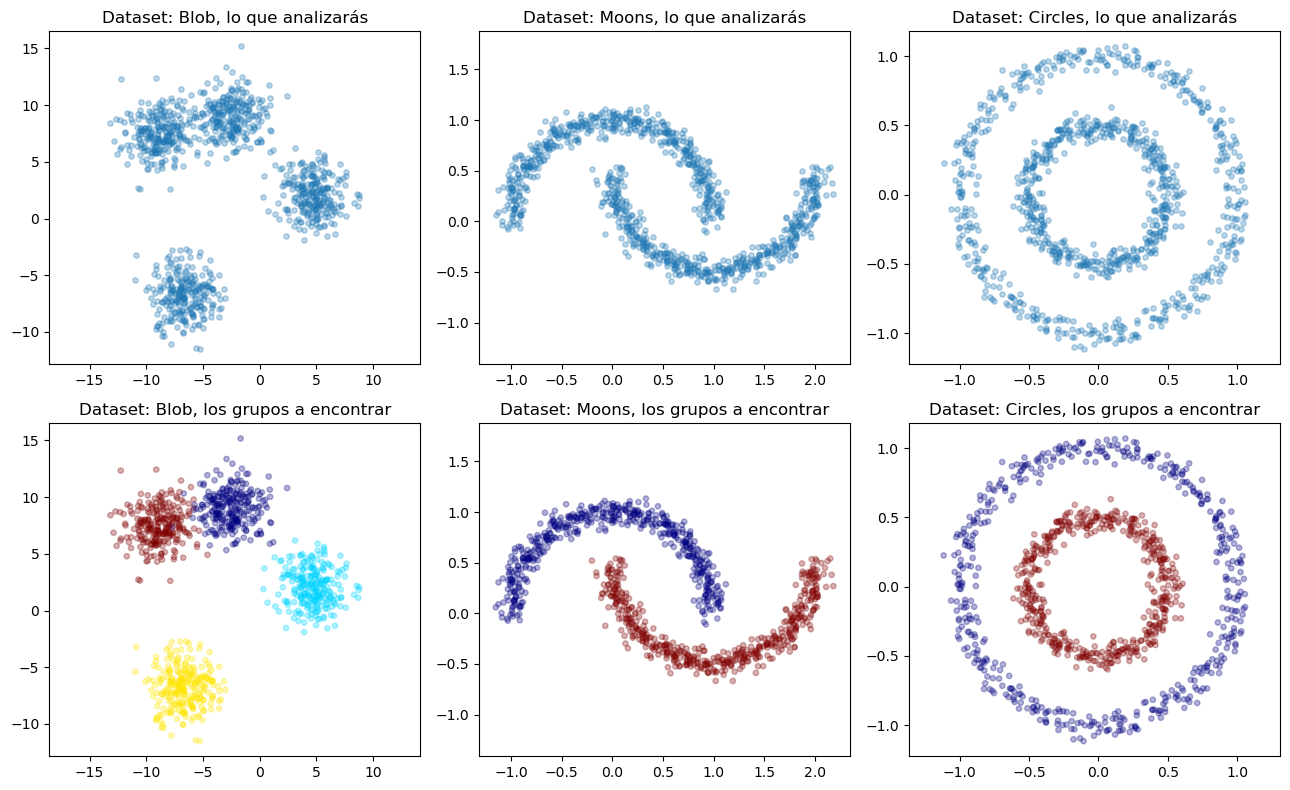

In [3]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('lo que analizarás' if i < 3 else 'los grupos a encontrar'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
    ax.axis('equal')
plt.tight_layout()

### 1 a. K-means

En este apartado se pide probar el algoritmo *k-means* sobre los tres datasets presentados anteriormente ajustando con los parámetros adecuados y analizar sus resultados.

In [4]:
X, y = X_blobs, y_blobs

Para estimar el número de clusters a detectar por *k-means*. Una técnica para estimar $k$ es, como se explica en la teoría:
> Los criterios anteriores (minimización de distancias intra grupo o maximización de distancias inter grupo) pueden usarse para establecer un valor adecuado para el parámetro k. Valores k para los que ya no se consiguen mejoras significativas en la homogeneidad interna de los segmentos o la heterogeneidad entre segmentos distintos, deberían descartarse.

Lo que popularmente se conocer como *regla del codo*.

Primero es necesario calcular la suma de los errores cuadráticos ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consiste en la suma de todos los errores (distancia de cada punto a su centroide asignado) al cuadrado.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

Donde $K$ es el número de clusters a buscar por *k-means*, $x \in C_i$ son los puntos que pertenecen a i-ésimo cluster, $c_i$ es el centroide del cluster $C_i$ (al que pertenece el punto $x$), y $euclidean$ es la [distancia euclídea](https://en.wikipedia.org/wiki/Euclidean_distance).

Este procedimiento realizado para cada posible valor $k$, resulta en una función monótona decreciente, donde el eje $x$ representa los distintos valores de $k$, y el eje $y$ el $SSE$. Intuitivamente se podrá observar un significativo descenso del error, que indicará el valor idóneo de $k$.

**Se pide realizar la representación gráfica de la regla del codo junto a su interpretación, utilizando la librería ```matplotlib``` y la implementación en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Blobs.
</div>

C:\Users\e17r1\anaconda3\envs\uoc20221pec2\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


La suma de los errores cuadraticos (SEE): [69844.4403836365, 34688.49595512937, 10326.862522617093, 4943.410788738868, 4480.592459923933, 4026.0221832561565, 3568.545545487932, 3176.3064929507354, 2899.3188508408416, 2634.4635059591033]


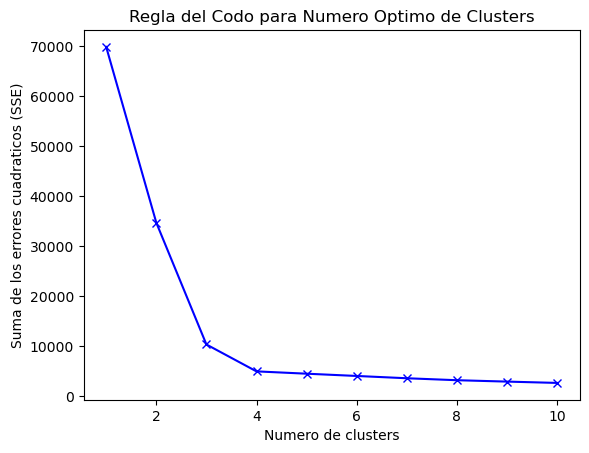

In [5]:
#Encontrar el numero optimo de clusters al hacer la suma de los errores cuadraticos o suma de las distancias cuadraticas

sse = []
#Probar los clusters para los tamanos del 1 al 11
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    sse.append(km.inertia_)
    
print("La suma de los errores cuadraticos (SEE):", sse)

#Graficar el SSE basado en el numero de clusters
plt.plot(K, sse, 'bx-')
plt.xlabel('Numero de clusters')
plt.ylabel('Suma de los errores cuadraticos (SSE)')
plt.title('Regla del Codo para Numero Optimo de Clusters')
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

El codo se encuentra cuando el numero de clusters es 3. Esto significa que los clusters son lo suficientemente compactos, mas alla de este numero ya no existe mayor diferencia. 

La Suma de los Errores Cuadraticos (SSE) representa la homogeneidad interna de los clusters. Por lo tanto, una mejor eleccion de *k* se lograria complementadolo con la utilizacion de medidas que representen la heterogeneidad entre los clusters. Otra manera seria el de permitir modificar el numero *k* cuando ejecutemos el algoritmo. Asi, podremos incrementar o disminuir los clusters si vemos necesario. 

Fuente: Mineria de datos : Modelos y algoritmos, pag. 120-122.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Blobs.
</div>

Con los resultados de la Suma de los Errores Cuadraticos (SSE) procedemos a utilizar 3 como el número de clusters para el modelo K-Means.

In [6]:
#Creamos el modelo
clusteringKmeans1 = KMeans(n_clusters=3) 

#Aplicamos el modelo 
clusteringKmeans1.fit(X) 

#Convertimos el array X en una dataframe
df_blobs = pd.DataFrame(X, columns = ['Feature1','Feature2'])

#Los resultados se guardan en labels_, estos los colocamos en una nueva columna llamada KMeans_Clusters
df_blobs["KMeansClusters"]=clusteringKmeans1.labels_ 

df_blobs.head(5)

Feature1  Feature2  KMeansClusters
0 -8.385067  6.909275               2
1 -5.692275 -6.401241               0
2 -5.986304 -6.758501               0
3  3.904901  0.613419               1
4  4.224533 -0.431859               1

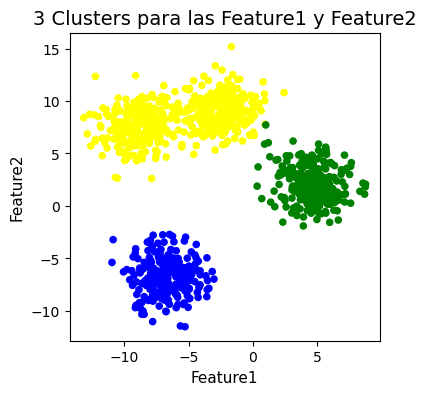

In [7]:
#Graficamos los clusters para las features 
fig = plt.figure(figsize = (4,4))

ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Feature1", fontsize=11)
ax.set_ylabel("Feature2", fontsize=11)
ax.set_title("3 Clusters para las Feature1 y Feature2", fontsize=14)

color_theme = np.array(["blue", "green", "yellow"])
ax.scatter(x=df_blobs["Feature1"], y=df_blobs["Feature2"], c=color_theme[df_blobs["KMeansClusters"]], s=20)

plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado. 
</div>

El codo indica 3 clusters, pero visualmente podemos identificar 4 clusters. Esto sucede porque dos clusters estan casi unidos por lo que el algoritmo mostro el mayor cambio de la Suma de Errores Cuadraticos en 3 clusters en vez de 4. Sin embargo, si tenemos conocimiento previo, como por ejemplo conocimiento de dominio o el objetivo es necesariamente 4 clusters, entonces utilizariamos los 4 clusters. Este es una de las desventajas de K-Means, *k* es necesario saber previamente. 

In [8]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Moons.
</div>

C:\Users\e17r1\anaconda3\envs\uoc20221pec2\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


La suma de los errores cuadraticos (SEE): [1003.4691966250365, 407.8563101620518, 275.15617813000307, 177.66406681098601, 133.2478524069371, 92.97543206064202, 74.77382714309671, 56.58035034109612, 46.930295110160145, 38.61663723653098]


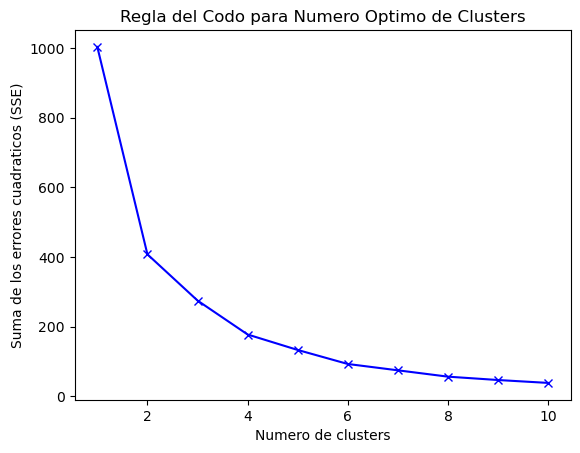

In [9]:
#Encontrar el numero optimo de clusters al hacer la suma de los errores cuadraticos o suma de las distancias cuadraticas

sse = []
#Probar los clusters para los tamanos del 1 al 11
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    sse.append(km.inertia_)
    
print("La suma de los errores cuadraticos (SEE):", sse)

#Graficar el SSE basado en el numero de clusters
plt.plot(K, sse, 'bx-')
plt.xlabel('Numero de clusters')
plt.ylabel('Suma de los errores cuadraticos (SSE)')
plt.title('Regla del Codo para Numero Optimo de Clusters')
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

La grafica nos indica que el codo se encuentra en 2 como numero de clusters apropiado. El numero de *k* podria mejorarse con conocimiento previo de cuantos clusters existen, ya sea por conocimiento de dominio o si visualizamos las instancias en una grafica. Sin embargo, segun la visualizacion se puede determinar que K-Means no es el algoritmo adecuado de agrupamiento.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Moons.
</div>

Con los resultados de la Suma de los Errores Cuadraticos (SSE) procedemos a utilizar 2 como el número de clusters para el modelo K-Means.

In [10]:
#Creamos el modelo
clusteringKmeans2 = KMeans(n_clusters=2) 

#Aplicamos el modelo 
clusteringKmeans2.fit(X) 

#Convertimos el array X en una dataframe
df_moons = pd.DataFrame(X, columns = ['Feature1','Feature2'])

#Los resultados se guardan en labels_, estos los colocamos en una nueva columna llamada KMeans_Clusters
df_moons["KMeansClusters"]=clusteringKmeans2.labels_ 

df_moons.head(5)

Feature1  Feature2  KMeansClusters
0 -0.033411  0.421391               1
1  0.998827 -0.442890               0
2  0.889592 -0.327843               0
3  0.341958 -0.417690               0
4 -0.838531  0.532375               1

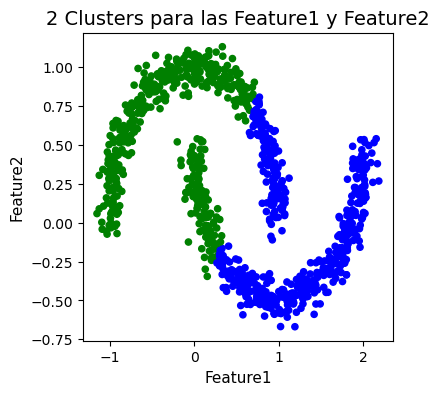

In [11]:
#Graficamos los clusters para las features 
fig = plt.figure(figsize = (4,4))

ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Feature1", fontsize=11)
ax.set_ylabel("Feature2", fontsize=11)
ax.set_title("2 Clusters para las Feature1 y Feature2", fontsize=14)

color_theme = np.array(["blue", "green"])
ax.scatter(x=df_moons["Feature1"], y=df_moons["Feature2"], c=color_theme[df_moons["KMeansClusters"]], s=20)

plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

K-means se basa en la distancia euclidea, por lo que reconoce como elementos de un cluster los que se encuentran mas cerca. De esta manera, K-means es recomendable cuando tenemos clusters de forma esferica o convexa, pero no funciona correctamente cuando los clusters tienen formas mas arbitrarias. En este caso podriamos usar algoritmos como DBSCAN, el cual localiza regiones de alta densidad que están separadas entre sí por regiones de baja densidad.

In [12]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Circles.
</div>

C:\Users\e17r1\anaconda3\envs\uoc20221pec2\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


La suma de los errores cuadraticos (SEE): [626.2414927497726, 397.24853916927543, 239.27097808623586, 168.6244496860455, 132.37796512531816, 111.57323258354008, 100.44722198742896, 88.38892405823688, 78.30270847102659, 67.68580960286785]


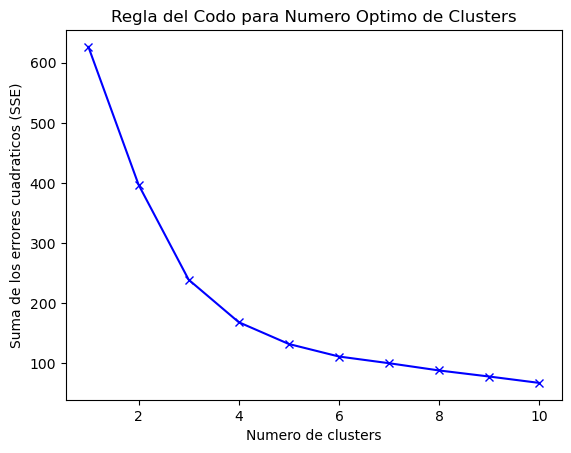

In [13]:
#Encontrar el numero optimo de clusters al hacer la suma de los errores cuadraticos o suma de las distancias cuadraticas

sse = []
#Probar los clusters para los tamanos del 1 al 11
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    sse.append(km.inertia_)
    
print("La suma de los errores cuadraticos (SEE):", sse)

#Graficar el SSE basado en el numero de clusters
plt.plot(K, sse, 'bx-')
plt.xlabel('Numero de clusters')
plt.ylabel('Suma de los errores cuadraticos (SSE)')
plt.title('Regla del Codo para Numero Optimo de Clusters')
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

En este caso, el codo no es obvio debido a que el valor de SSE decrece gradualmente. Sin embargo, podemos escoger el numero de clusters 4 o 5, porque mas alla de estos numeros el cambio es menos significativo.  

*k* podria mejorarse teniendo conocimiento previo o calculando las distancias intergrupos. 

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Circles.
</div>

In [14]:
#Creamos el modelo
clusteringKmeans3 = KMeans(n_clusters=4) 

#Aplicamos el modelo 
clusteringKmeans3.fit(X) 

#Convertimos el array X en una dataframe
df_circles = pd.DataFrame(X, columns = ['Feature1','Feature2'])

#Los resultados se guardan en labels_, estos los colocamos en una nueva columna llamada KMeans_Clusters
df_circles["KMeansClusters"]=clusteringKmeans3.labels_ 

df_circles.head(5)

Feature1  Feature2  KMeansClusters
0  0.452592  0.168433               2
1 -0.438027  0.119900               3
2 -0.532224  0.184359               3
3 -0.301402  0.400782               0
4  0.445602 -0.894936               1

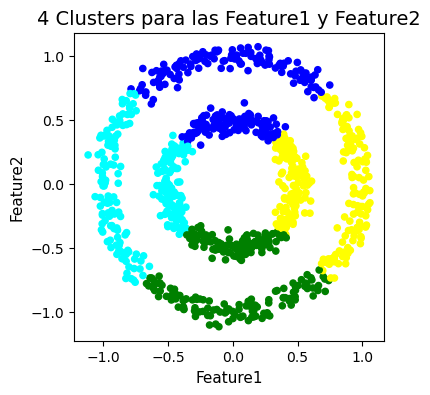

In [15]:
#Graficamos los clusters para las features 
fig = plt.figure(figsize = (4,4))

ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Feature1", fontsize=11)
ax.set_ylabel("Feature2", fontsize=11)
ax.set_title("4 Clusters para las Feature1 y Feature2", fontsize=14)

color_theme = np.array(["blue", "green", "yellow", "cyan"])
ax.scatter(x=df_circles["Feature1"], y=df_circles["Feature2"], c=color_theme[df_circles["KMeansClusters"]], s=20)

plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

De manera similar al anterior caso, K-means se basa en la distancia euclidea, lo que significa que escoge las instancias que pertenecen a un cluster dependiendo en que tan lejos se encuentra del centroide. Este forma de agrupar funciona para clusters de forma esferica, pero no para otro tipo de clusters. En este caso, los circulos estan divididos en 4 clusters y no en 2. Las instancias de los clusters se basan en la distancia y no en la densidad. 

### 1 b. Algoritmos basados en densidad: DBSCAN

En este apartado se pide aplicar clustering por densidad como [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) a los datasets anteriores para detectar los dos grupos subyacentes.

Ésta es una visualización intuitiva de su funcionamiento: https://www.youtube.com/watch?v=RDZUdRSDOok

In [16]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN en scikit-learn</a> jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Blobs.
</div>

Como sabemos de antemano que existen 4 clusters en el dataset, nos aseguramos que los parametros (epsilon y minPts) de DBSCAN den como resultado la formación de 5 clusters (4 grupos y 1 de outliers).

In [17]:
df_blobs = pd.DataFrame(X, columns = ['Feature1','Feature2'])

#Modelo DBSCAN 1
clusteringDBSCAN1 = DBSCAN(eps=1.6, min_samples=60).fit(df_blobs)
cluster = clusteringDBSCAN1.labels_
print("El numero de clusters (incluidos los outliers) es: " + str(len(set(cluster))))

El numero de clusters (incluidos los outliers) es: 5


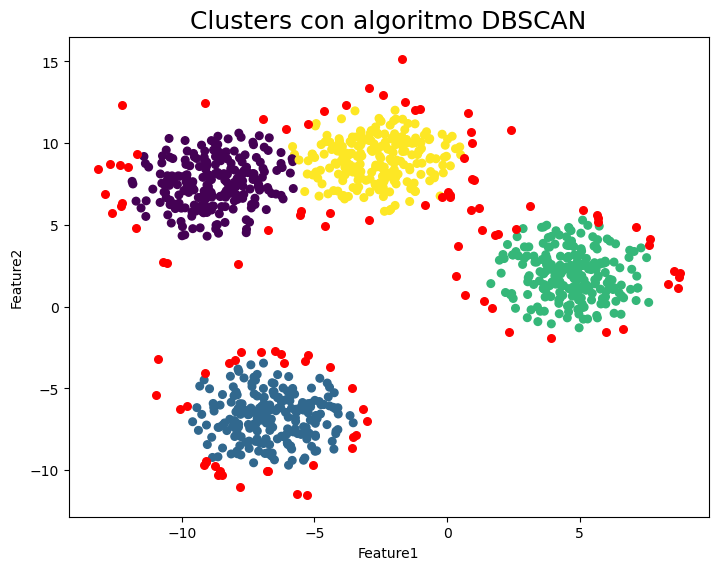

In [18]:
#Separar outliers de clusters
outliers_df = df_blobs [clusteringDBSCAN1.labels_ == -1]
clusters_df = df_blobs [clusteringDBSCAN1.labels_ != -1]

np.random.seed(10)
colors = clusteringDBSCAN1.labels_
colors_clusters = colors[colors != -1]
color_outliers = "red"

#Graficar clusters y outliers
fig = plt.figure()

ax = fig.add_axes([.1, .1, 1, 1])

ax.scatter(clusters_df["Feature1"], clusters_df["Feature2"], c = colors_clusters, s=30)
ax.scatter(outliers_df["Feature1"], outliers_df["Feature2"], c = color_outliers, s=30)

ax.set_xlabel("Feature1")
ax.set_ylabel("Feature2")
plt.title("Clusters con algoritmo DBSCAN", fontsize=18)

plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

El algoritmo DBSCAN, con los parametros *eps* y *minimun samples* adecuados, reconoce los clusters basados en la densidad. Tambien reconoce los outliers (puntos rojos) que no pertenecen a los 4 clusters. 

In [19]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBSCAN jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Moons.
</div>

Como sabemos de antemano que existen 2 clusters en el dataset, nos aseguramos que los parametros (epsilon y minPts) de DBSCAN den como resultado la formación de 3 agrupaciones (2 grupos y 1 de outliers).

In [20]:
df_moons = pd.DataFrame(X, columns = ['Feature1','Feature2'])

#Modelo DBSCAN 1
clusteringDBSCAN2 = DBSCAN(eps=0.15, min_samples=20).fit(df_moons)
cluster2 = clusteringDBSCAN2.labels_
print("El numero de clusters (incluidos los outliers) es: " + str(len(set(cluster2))))

El numero de clusters (incluidos los outliers) es: 3


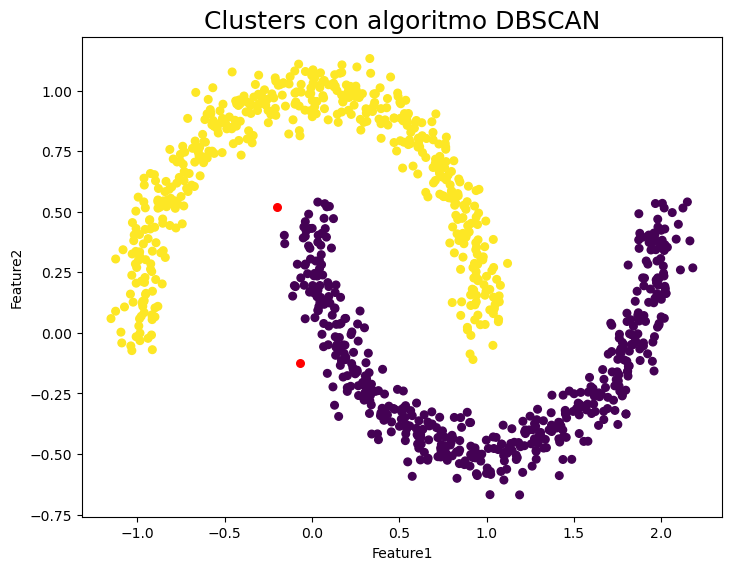

In [21]:
#Separar outliers de clusters
outliers_df2 = df_moons[clusteringDBSCAN2.labels_ == -1]
clusters_df2 = df_moons[clusteringDBSCAN2.labels_ != -1]

np.random.seed(10)
colors = clusteringDBSCAN2.labels_
colors_clusters = colors[colors != -1]
color_outliers = "red"

#Graficar clusters y outliers
fig = plt.figure()

ax = fig.add_axes([.1, .1, 1, 1])

ax.scatter(clusters_df2["Feature1"], clusters_df2["Feature2"], c = colors_clusters, s=30)
ax.scatter(outliers_df2["Feature1"], outliers_df2["Feature2"], c = color_outliers, s=30)

ax.set_xlabel("Feature1")
ax.set_ylabel("Feature2")
plt.title("Clusters con algoritmo DBSCAN", fontsize=18)

plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

En este caso, la agrupacion de los clusters se ha hecho correctamente, en contraste con la realizada con el algoritmo K-means. Esto se debe a que DBSCAN agrupa basado en la densidad de las intancias y no solo en la cercania de estas. De esta manera, es el algoritmo adecuado para clasificar clusters de formas no circules. 

In [22]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBScan jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Circles.
</div>

Como sabemos de antemano que existen 2 clusters en el dataset, nos aseguramos que los parametros (epsilon y minPts) de DBSCAN den como resultado la formación de 3 agrupaciones (2 grupos y 1 de outliers).

In [23]:
df_circles = pd.DataFrame(X, columns = ['Feature1','Feature2'])

#Modelo DBSCAN 1
clusteringDBSCAN3 = DBSCAN(eps=0.1, min_samples=10).fit(df_circles)
cluster3 = clusteringDBSCAN3.labels_
print("El numero de clusters (incluidos los outliers) es: " + str(len(set(cluster3))))

El numero de clusters (incluidos los outliers) es: 3


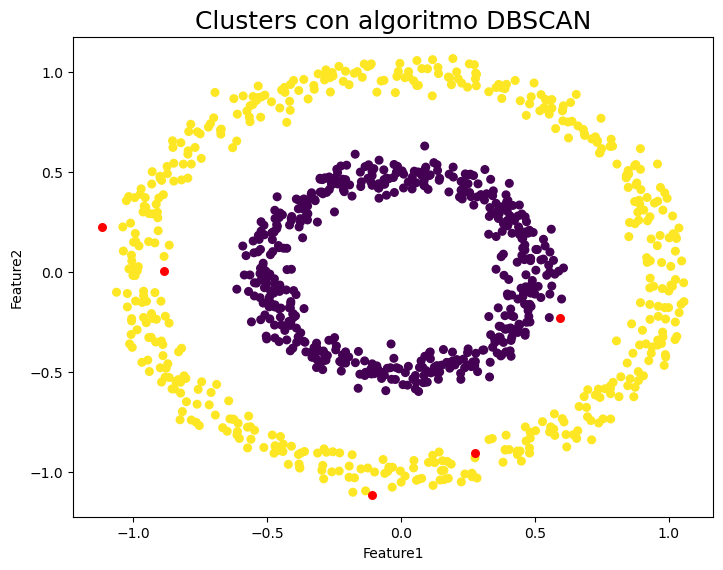

In [24]:
#Separar outliers de clusters
outliers_df3 = df_circles[clusteringDBSCAN3.labels_ == -1]
clusters_df3 = df_circles[clusteringDBSCAN3.labels_ != -1]

np.random.seed(10)
colors = clusteringDBSCAN3.labels_
colors_clusters = colors[colors != -1]
color_outliers = "red"

#Graficar clusters y outliers
fig = plt.figure()

ax = fig.add_axes([.1, .1, 1, 1])

ax.scatter(clusters_df3["Feature1"], clusters_df3["Feature2"], c = colors_clusters, s=30)
ax.scatter(outliers_df3["Feature1"], outliers_df3["Feature2"], c = color_outliers, s=30)

ax.set_xlabel("Feature1")
ax.set_ylabel("Feature2")
plt.title("Clusters con algoritmo DBSCAN", fontsize=18)

plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

De manera similar al anterior caso, el algoritmo DBSCAN con los parametros adecuados para epsilon y minPoints obtiene los 2 clusters y los outliers. Esto se debe a que el algoritmo se basa en la densidad de los puntos, reconociendo asi figuras no circulares. 

### 1 c. Algoritmos jerárquicos

En este apartado se pide visualizar mediante un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcción progresiva de los grupos mediante un algoritmo jerárquico aglomerativo (estrategia *bottom-up*). Con ello se pretende encontrar un método gráfico para entender el comportamiento del algoritmo y encontrar los *clusters* deseados en cada dataset.

In [25]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Blobs.<br>
Puedes importar las librerías necesarias para ello.
</div>

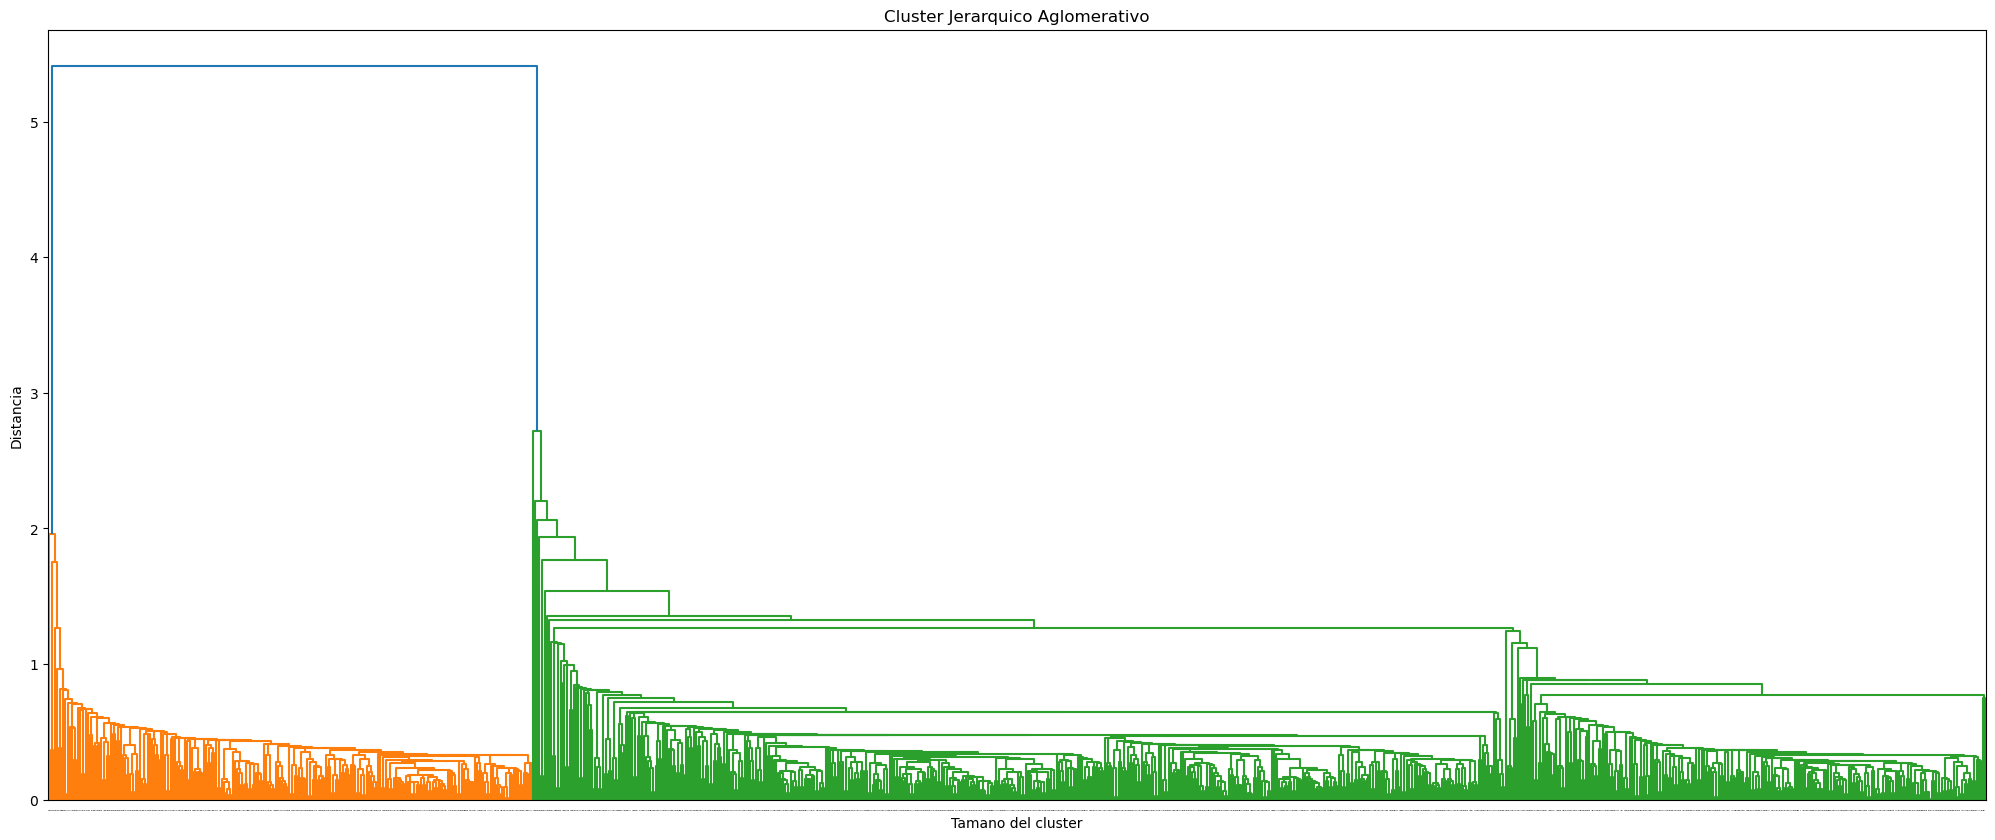

In [26]:
#Creamos el linkage del clustering
Z = linkage(X, 'single')

#Graficamos el dendrograma
plt.figure(figsize = (25,10))
plt.title('Cluster Jerarquico Aglomerativo')
plt.xlabel('Tamano del cluster')
plt.ylabel('Distancia')

dendrogram(Z, leaf_rotation=0., leaf_font_size=.01)

plt.show()

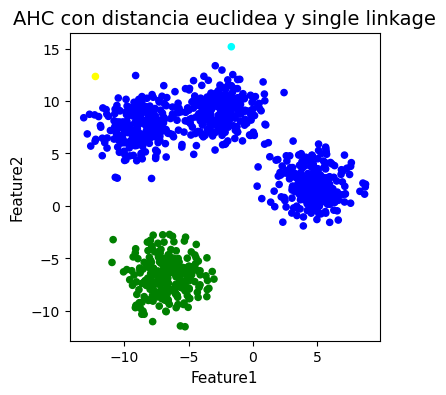

In [27]:
#Clustering Jerarquico Aglomerativo con distancia euclidea y linkage single
k=4
HClustering = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='single')
HClustering.fit(X)

#Graficamos los clusters
fig = plt.figure(figsize = (4,4))

ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Feature1", fontsize=11)
ax.set_ylabel("Feature2", fontsize=11)
ax.set_title("AHC con distancia euclidea y single linkage", fontsize=14)

color_theme = np.array(["blue", "green", "yellow", "cyan"])
ax.scatter(x=X[:,0], y=X[:,1], c=color_theme[HClustering.labels_], s=20)

plt.show()

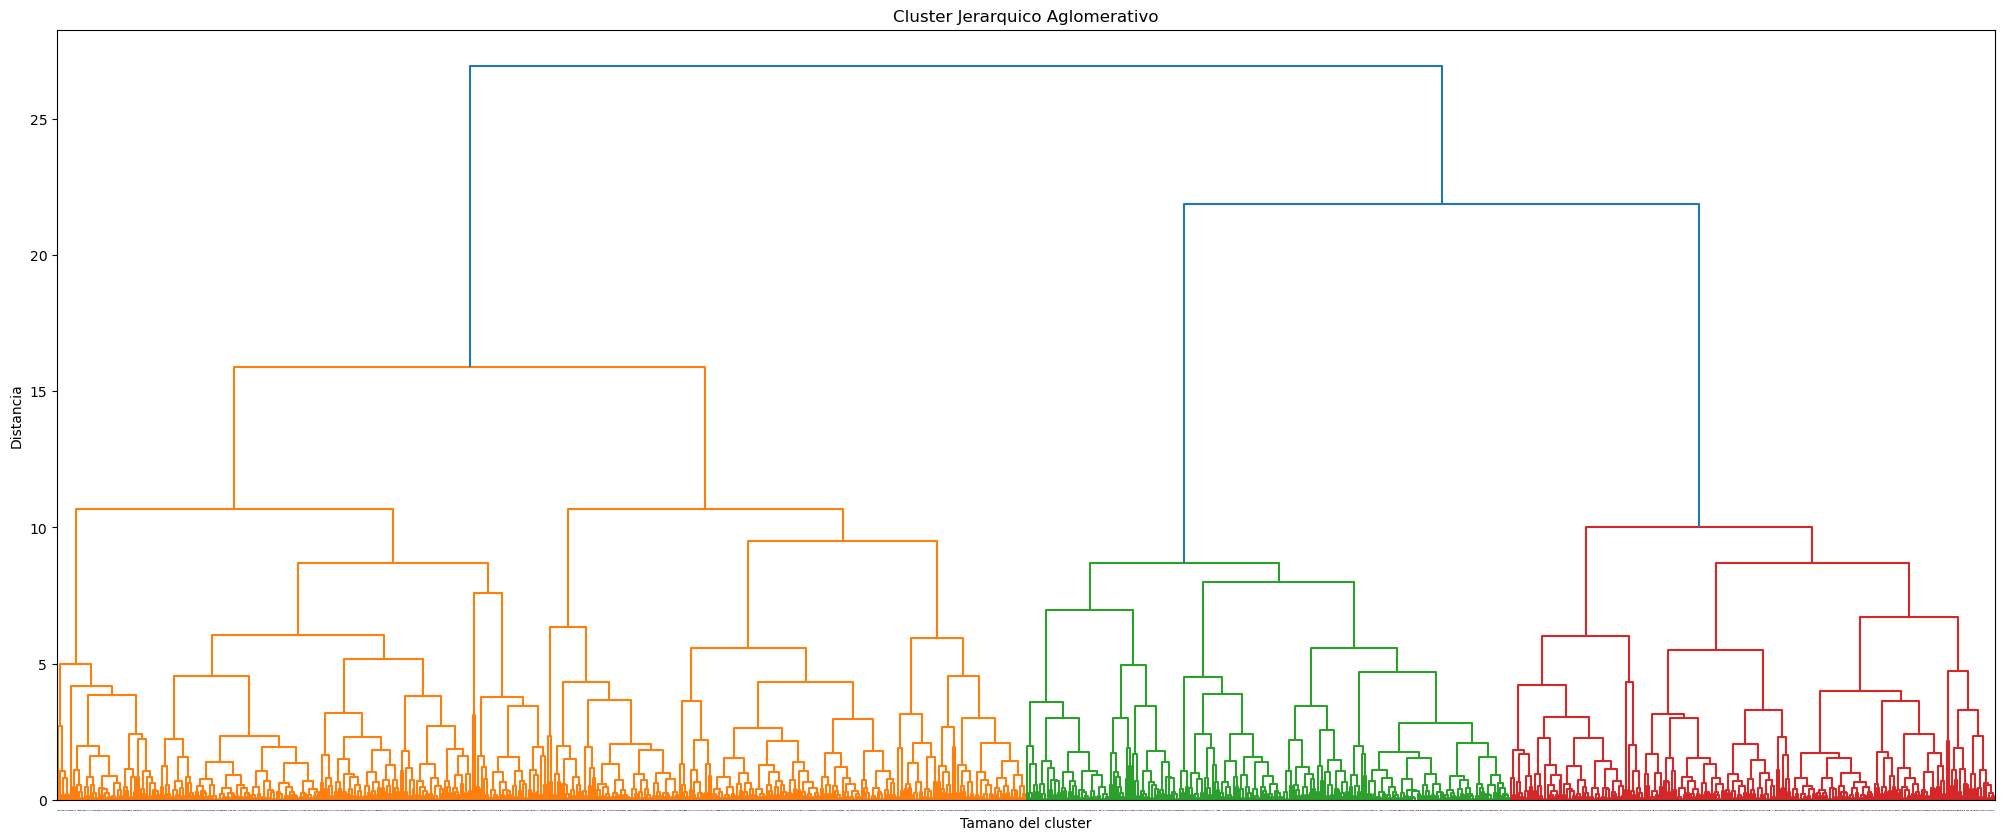

In [28]:
#Creamos el linkage del clustering
Z = linkage(X, 'complete')

#Graficamos el dendrograma
plt.figure(figsize = (25,10))
plt.title('Cluster Jerarquico Aglomerativo')
plt.xlabel('Tamano del cluster')
plt.ylabel('Distancia')

dendrogram(Z, leaf_rotation=0., leaf_font_size=.01)

plt.show()

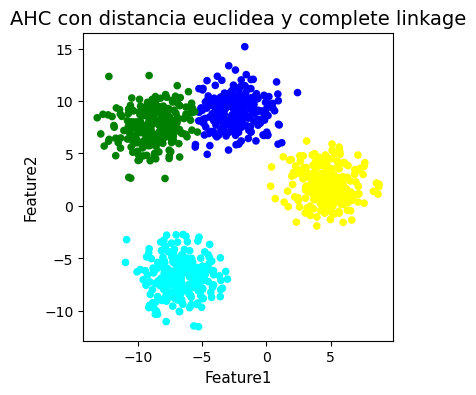

In [29]:
#Clustering Jerarquico Aglomerativo con distancia euclidea y linkage complete

k=4
HClustering = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='complete')
HClustering.fit(X)

#Graficamos los clusters
fig = plt.figure(figsize = (4,4))

ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Feature1", fontsize=11)
ax.set_ylabel("Feature2", fontsize=11)
ax.set_title("AHC con distancia euclidea y complete linkage", fontsize=14)

color_theme = np.array(["blue", "green", "yellow", "cyan"])
ax.scatter(x=X[:,0], y=X[:,1], c=color_theme[HClustering.labels_], s=20)

plt.show()

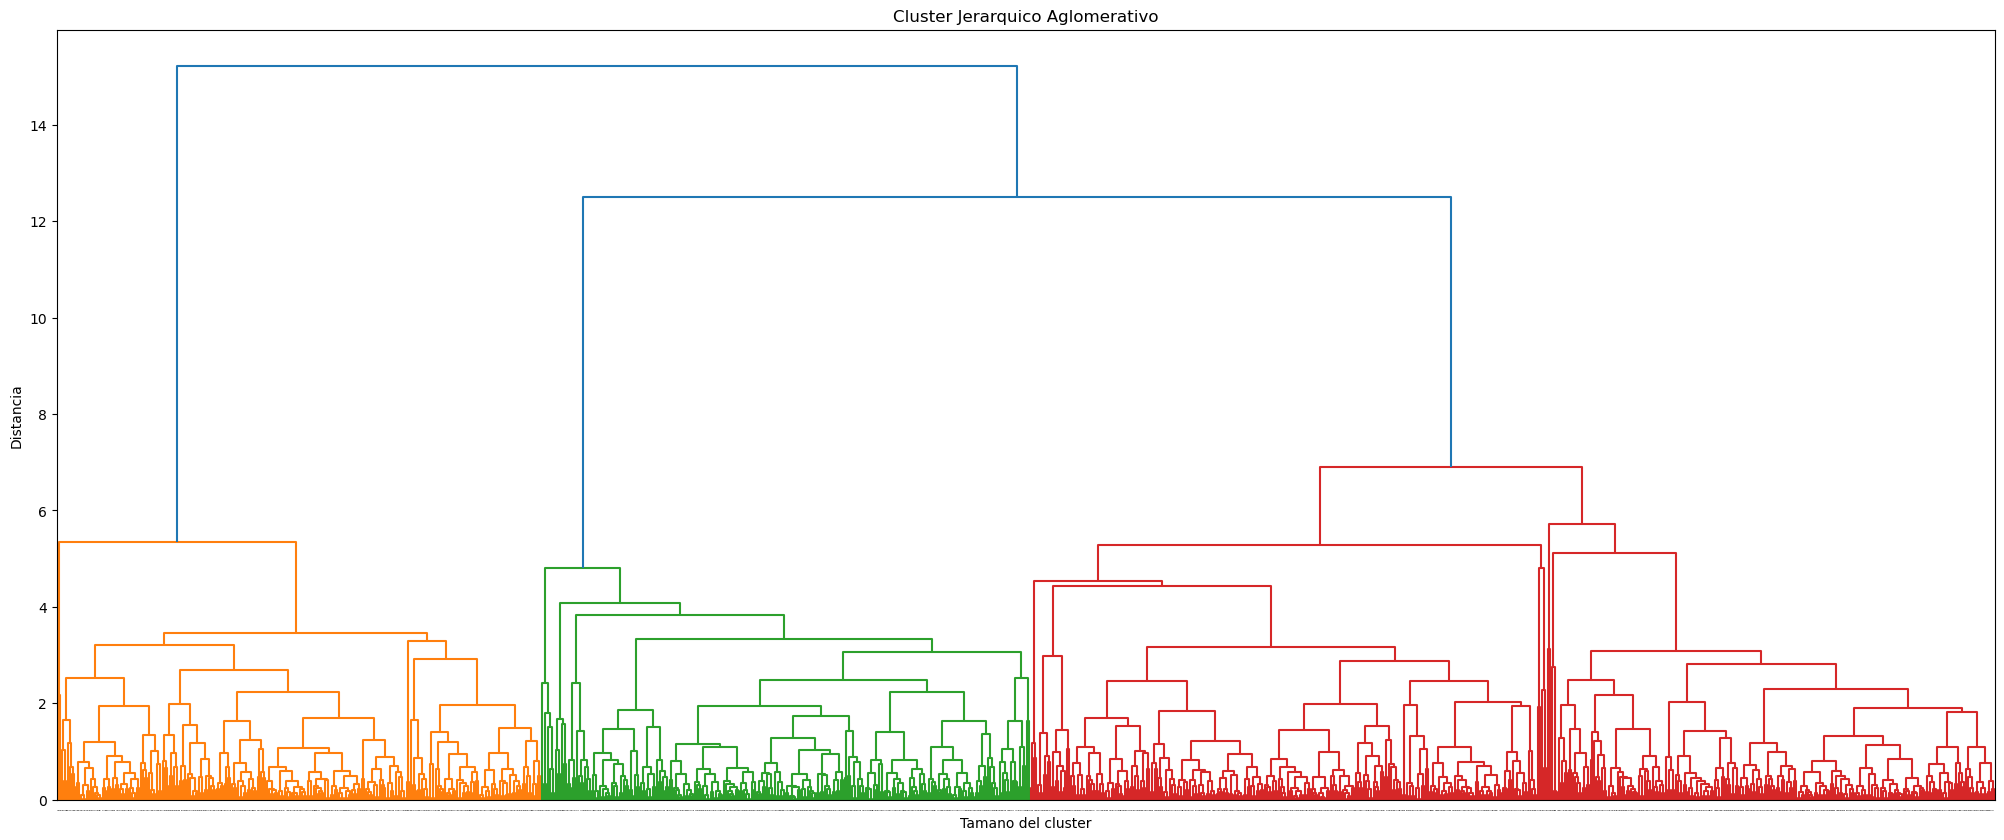

In [30]:
#Creamos el linkage del clustering
Z = linkage(X, 'average')

#Graficamos el dendrograma
plt.figure(figsize = (25,10))
plt.title('Cluster Jerarquico Aglomerativo')
plt.xlabel('Tamano del cluster')
plt.ylabel('Distancia')

dendrogram(Z, leaf_rotation=0., leaf_font_size=.01)

plt.show()

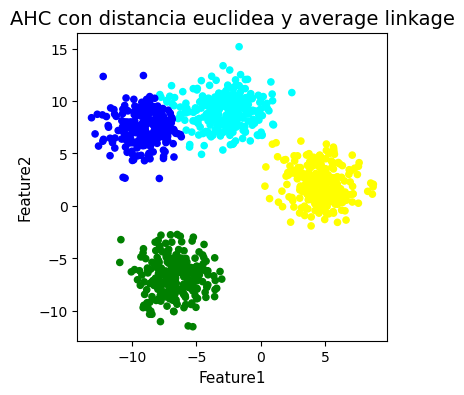

In [31]:
#Clustering Jerarquico Aglomerativo con distancia euclidea y linkage average

k=4
HClustering = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='average')
HClustering.fit(X)

#Graficamos los clusters
fig = plt.figure(figsize = (4,4))

ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Feature1", fontsize=11)
ax.set_ylabel("Feature2", fontsize=11)
ax.set_title("AHC con distancia euclidea y average linkage", fontsize=14)

color_theme = np.array(["blue", "green", "yellow", "cyan"])
ax.scatter(x=X[:,0], y=X[:,1], c=color_theme[HClustering.labels_], s=20)

plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

En el caso del agrupamiento con linkage single vemos que solo se forman 2 clusters. Lo que parece que sucede es que single obliga "la unión de dos grupos que a priori deberían permanecer bien diferenciados, por el hecho de que estos comparten algún elemento muy próximo". El linkage complete tiene mejores resultados no produce ese efecto cadena como lo hace el linkage single. 

In [32]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Moons.<br>
Puedes importar las librerías necesarias para ello.
</div>

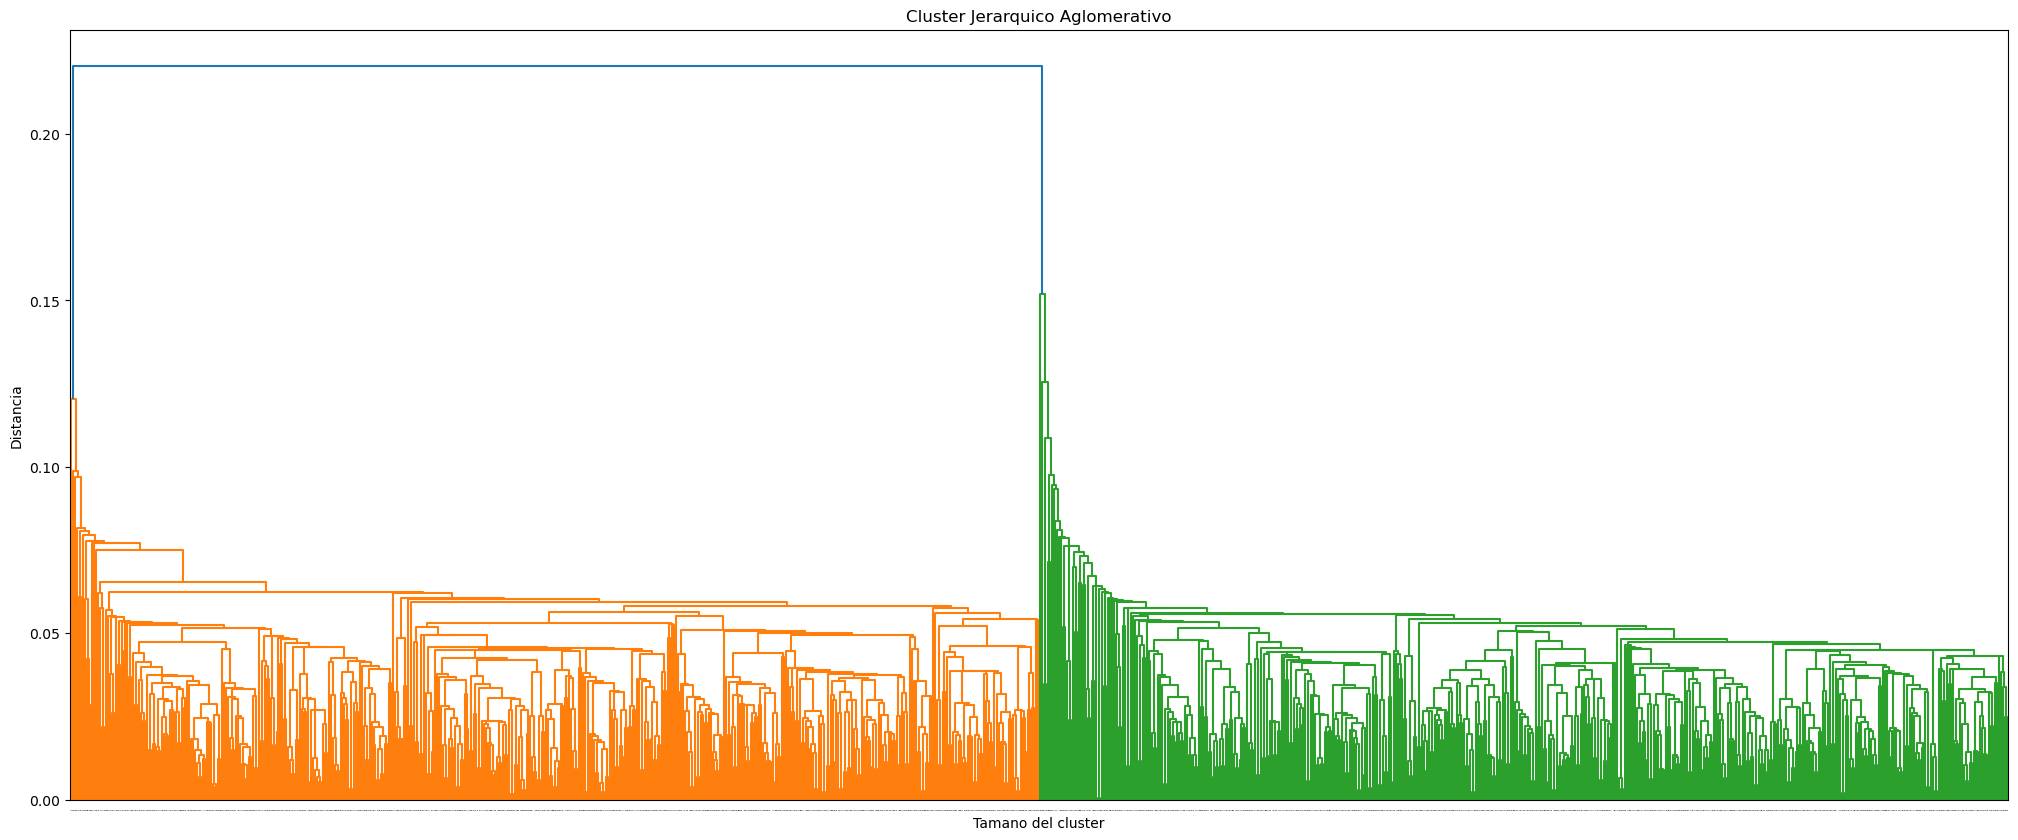

In [33]:
#Creamos el linkage del clustering
Z = linkage(X, 'single')

#Graficamos el dendrograma
plt.figure(figsize = (25,10))
plt.title('Cluster Jerarquico Aglomerativo')
plt.xlabel('Tamano del cluster')
plt.ylabel('Distancia')

dendrogram(Z, leaf_rotation=0., leaf_font_size=.01)

plt.show()

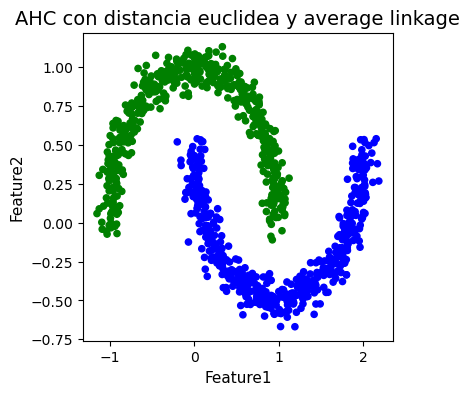

In [34]:
#Clustering Jerarquico Aglomerativo con distancia euclidea y linkage average

k=2
HClustering = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='single')
HClustering.fit(X)

#Graficamos los clusters
fig = plt.figure(figsize = (4,4))

ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Feature1", fontsize=11)
ax.set_ylabel("Feature2", fontsize=11)
ax.set_title("AHC con distancia euclidea y average linkage", fontsize=14)

color_theme = np.array(["blue", "green", "yellow", "cyan"])
ax.scatter(x=X[:,0], y=X[:,1], c=color_theme[HClustering.labels_], s=20)

plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

En este caso, el linkage single funciona mejor. Como vemos en el dendograma y en la grafica al utilizar la distancia minima entre las instancias esto produce un efecto cadena que agrupa que agrupa en clusteres a los puntos que no tienen bruscas separaciones. Comportandose de manera similar a el algoritmo DBSCAN.

In [35]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Circles.<br>
Puedes importar las librerías necesarias para ello.
</div>

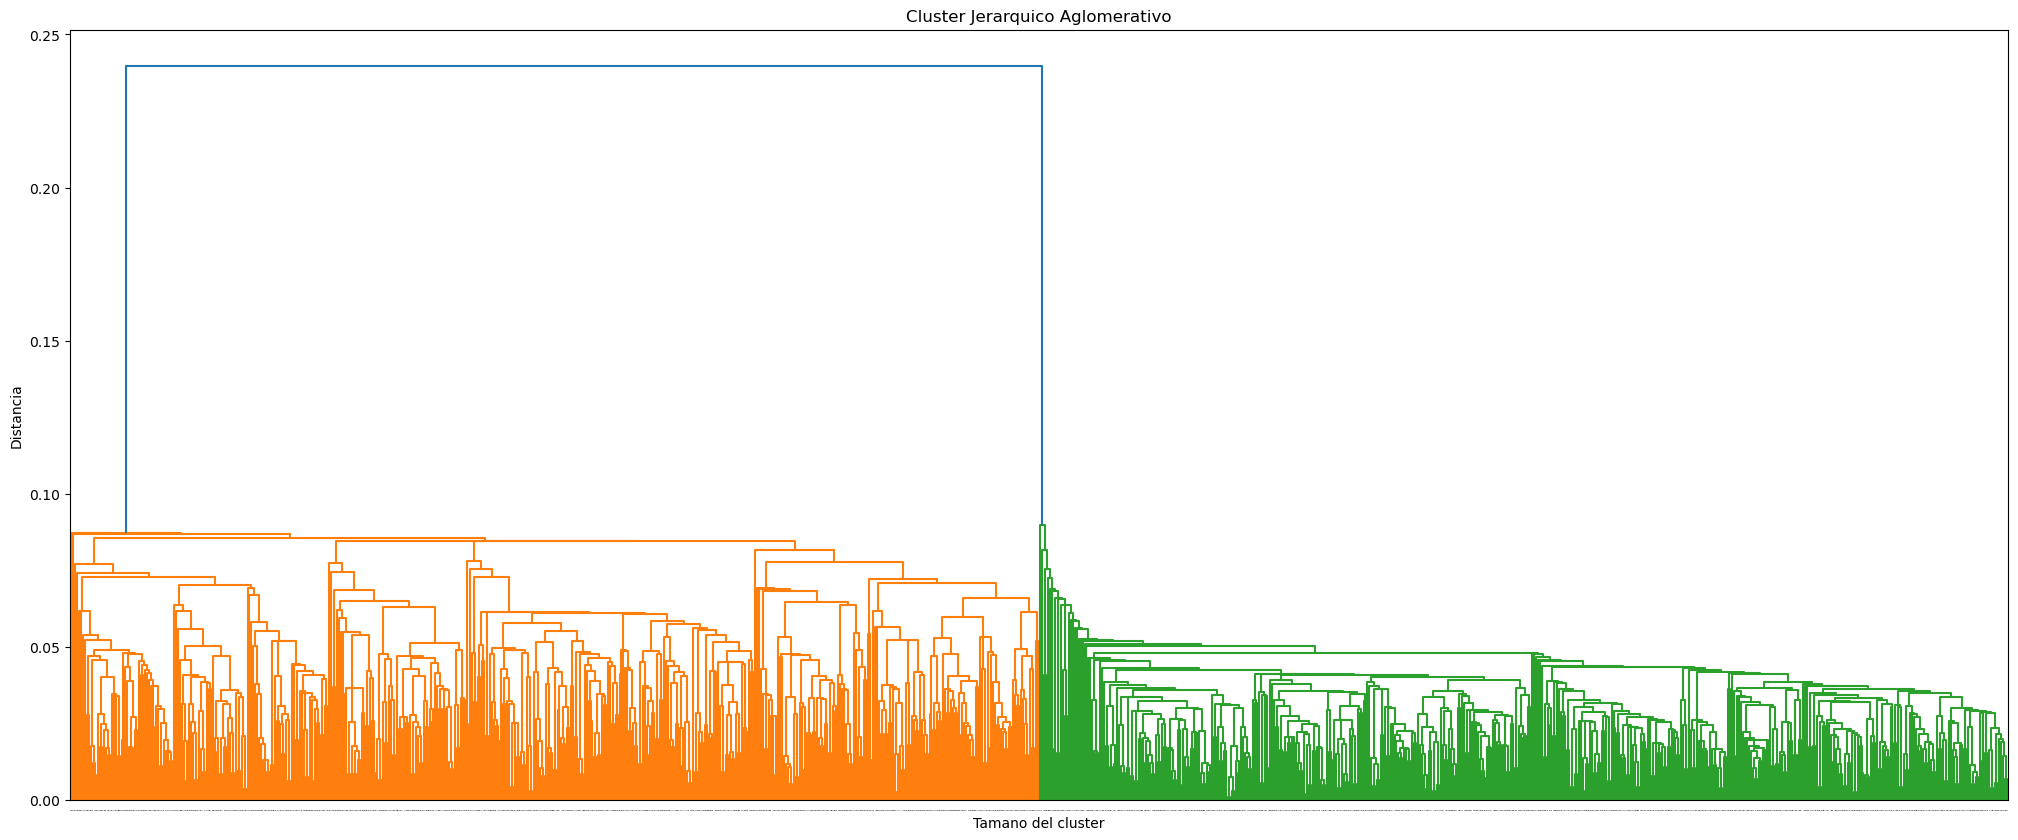

In [36]:
#Creamos el linkage del clustering
Z = linkage(X, 'single')

#Graficamos el dendrograma
plt.figure(figsize = (25,10))
plt.title('Cluster Jerarquico Aglomerativo')
plt.xlabel('Tamano del cluster')
plt.ylabel('Distancia')

dendrogram(Z, leaf_rotation=0., leaf_font_size=.01)

plt.show()

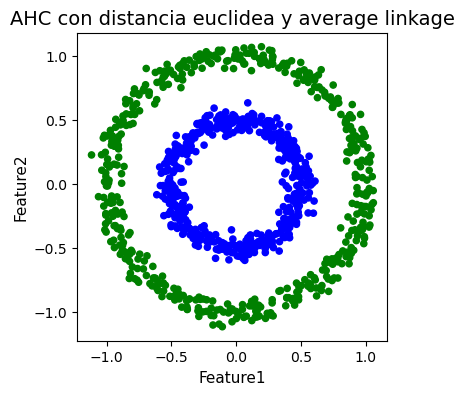

In [37]:
#Clustering Jerarquico Aglomerativo con distancia euclidea y linkage average
k=2
HClustering = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='single')
HClustering.fit(X)

#Graficamos los clusters
fig = plt.figure(figsize = (4,4))

ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Feature1", fontsize=11)
ax.set_ylabel("Feature2", fontsize=11)
ax.set_title("AHC con distancia euclidea y average linkage", fontsize=14)

color_theme = np.array(["blue", "green", "yellow", "cyan"])
ax.scatter(x=X[:,0], y=X[:,1], c=color_theme[HClustering.labels_], s=20)

plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

El dendograma claramente nos muestra la creacion de dos grandes clusters. Y en la grafica tambien podemos observar como el linkage single funciona mejor, por las mismas razones comentadas en el caso anterior. 

<a id="ej2"></a>

## 2. Ejemplo práctico: diseño de redes de transporte (5 puntos)

Imaginemos que un famoso magnate llamado Melon Mask ha culminado su nuevo invento: el hypermegaminiloop. Que revoluciona el transporte urbano, pero de momento es muy muy caro.

El alcalde de Nueva York se ha enterado de su existencia y quiere ser un *early adopter* del proyecto y complementar (que no sustituir) su red de transporte. Para ello se dispone de datos de la [demanda de Uber](https://data.world/data-society/uber-pickups-in-nyc) que con este nuevo método se pretende cubrir.

Se provee de un subconjunto del dato representativo pero de menor tamaño para evitar que su procesado conlleve tiempos de ejecución muy grandes.

In [38]:
df = pd.read_csv('uber_sample.csv')
df.head(3)

Date/Time      Lat      Lon    Base
0   9/16/2014 5:37:00  40.7651 -73.9615  B02764
1  9/21/2014 12:12:00  40.7249 -73.9947  B02764
2  9/22/2014 12:50:00  40.7720 -73.9590  B02598

Visualizamos los datos para ver donde hay mayor concentración de peticiones y facilitar el posterior análisis de los datos. ¿Puedes localizar *Central Park*?

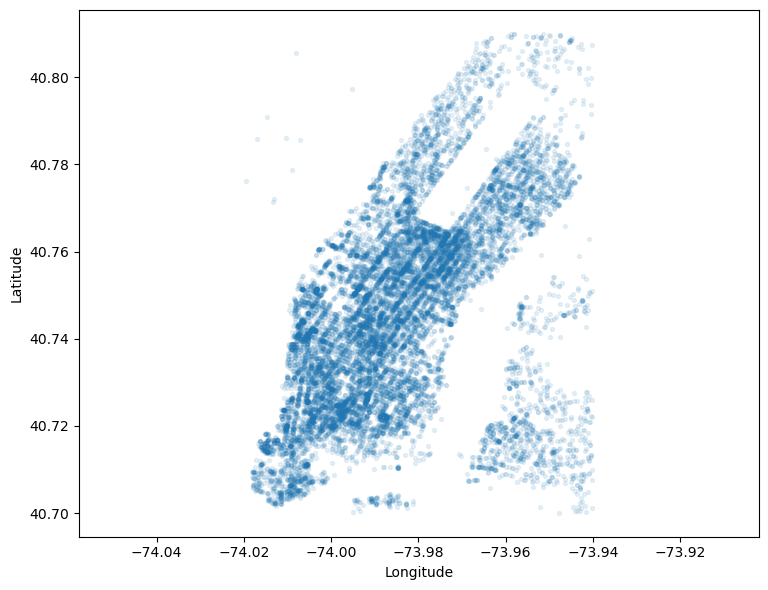

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(df['Lon'], df['Lat'], s=8, alpha=.1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.axis('equal')
plt.tight_layout()
plt.show()

### 2 a. Localización de las paradas: clustering

La primera parte del diseño de la red de transporte es situar las futuras paradas. Para ello tendrás que identificar entre 100 y 200 lugares del mapa (aproximación aportada por el departamento de transporte de la ciudad) con alta concentración de demanda.

Puedes elegir cualquier algoritmo de clustering para este cometido, pero recuerda que tendrás que justificar la respuesta para la propuesta de proyecto.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
elige y aplica una técnica de clustering para encontrar entre 100 y 200 grupos de puntos.
</div>

In [40]:
#Creamos el modelo
clusteringDBSCANNY = DBSCAN(eps=0.0006, min_samples=15)

#Aplicamos el modelo
clusteringDBSCANNY.fit(df[['Lat', 'Lon']])


cluster = clusteringDBSCANNY.labels_

#Los resultados se guardan en labels_, estos los colocamos en una nueva columna llamada DBSCANClusters
df["DBSCANClusters"] = clusteringDBSCANNY.labels_

print("El numero de clusters (incluidos los outliers) es: " + str(len(set(cluster))))

El numero de clusters (incluidos los outliers) es: 146


<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
visualiza los grupos encontrados dotando de color a los puntos en base al cluster al que pertenecen. Puedes utilizar el colormap 'tab20' para tener una paleta de color discreta y amplia que permita visualizar mejor los resultados.
</div>

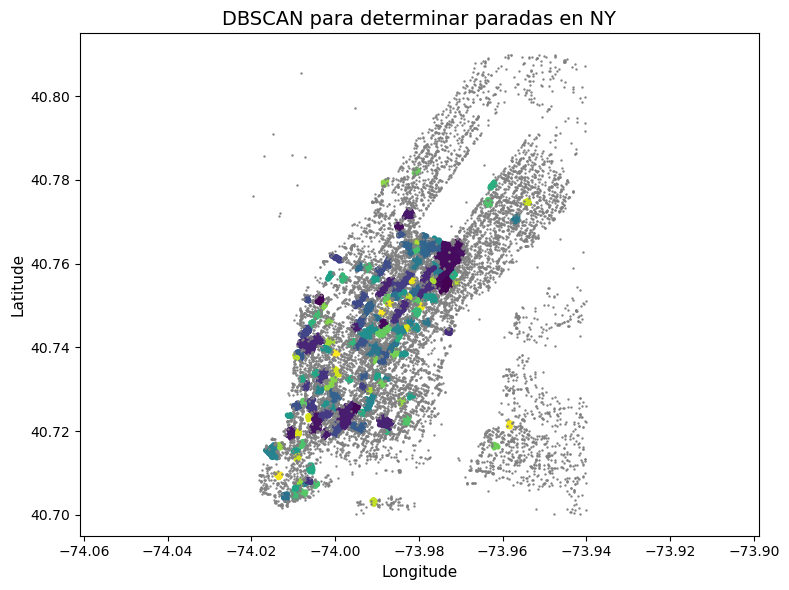

In [45]:
#Separar outliers de clusters
outliers_df = df[clusteringDBSCANNY.labels_ == -1]
clusters_df = df[clusteringDBSCANNY.labels_ != -1]

np.random.seed(10)
colors = clusteringDBSCANNY.labels_
colors_clusters = colors[colors != -1]
color_outliers = "gray"

#Graficar clusters y outliers
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(clusters_df["Lon"], clusters_df["Lat"], c = colors_clusters, s=8)
ax.scatter(outliers_df["Lon"], outliers_df["Lat"], c = color_outliers, s=0.5)

ax.set_xlabel("Longitude", fontsize=11)
ax.set_ylabel("Latitude", fontsize=11)
ax.set_title("DBSCAN para determinar paradas en NY", fontsize=14)

ax.axis('equal')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
    De cara a la redacción de la propuesta de proyecto, ¿por qué has elegido este método de agrupamiento?
</div>

El método de agrupamiento escogido es DBSCAN. Como se menciona en el enunciado, las paradas deben encontrarse en lugares con alta concentracion de demanda, por lo tanto, DBSCAN es adecuado para este tipo de problema ya que los clusters se formarían basados en la densidad de los puntos donde existe mas demanda de uber. Esto se diferencia de la utilizacion de K-Means, método que generaría un numero de clusters previamente determinado basado en la distancia euclidea, sin tomar en cuenta la densidad/demanda.   

### 2 b. Análisis de grupos y preparación de datos

Antes de continuar con el diseño de la red de transporte hay que validar que los grupos tienen sentido.

Lo primero es estimar la densidad de cada grupo encontrado:

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
calcula para cada cluster su área:
    <br/>
    1. Puedes simplificarla de la siguiente manera: (lat_max - lat_min) * (lon_max - lon_min), cuidado con los valores negativos, de los puntos que pertenecen al grupo.
    <br/>
    2. También calcula el número de puntos que pertenecen a cada grupo.
    <br/>
    3. Calcula el siguiente ratio: número de puntos (2) por área cubierta (1) de cada cluster.
    <br/>
    Por último, visualiza para cada cluster el resultado de este cálculo (3) en un diagrama de barras.
</div>

1. Puedes simplificarla de la siguiente manera: (lat_max - lat_min) * (lon_max - lon_min), cuidado con los valores negativos, de los puntos que pertenecen al grupo.

2. También calcula el número de puntos que pertenecen a cada grupo.

In [46]:
df.head(5)

Date/Time      Lat      Lon    Base  DBSCANClusters
0   9/16/2014 5:37:00  40.7651 -73.9615  B02764              -1
1  9/21/2014 12:12:00  40.7249 -73.9947  B02764               2
2  9/22/2014 12:50:00  40.7720 -73.9590  B02598              -1
3    9/5/2014 1:32:00  40.7259 -73.9905  B02617              -1
4    9/7/2014 9:04:00  40.7561 -73.9731  B02617               0

In [47]:
#Calcular la latitud y longitud mínima y máxima de cada cúmulo
#LATITUDE
lat_min = df[['Lat', 'DBSCANClusters']].groupby(by=["DBSCANClusters"]).min()
lat_max = df[['Lat', 'DBSCANClusters']].groupby(by=["DBSCANClusters"]).max()

#LONGITUDE
lon_min = df[['Lon', 'DBSCANClusters']].groupby(by=["DBSCANClusters"]).min()
lon_max = df[['Lon', 'DBSCANClusters']].groupby(by=["DBSCANClusters"]).max()

#Calcular la diferencia de latitud y longitud mínima y máxima. 
#Transformado a metros (un grado de latitud equivale a 111 km y un grado de longitud a unos 75 km)
Diff_Lat_km = (lat_max - lat_min) * 111
Diff_Lon_km = (lon_max - lon_min) * 75

#Crear un nuevo marco de datos con los 146 clústeres como índice y con la cantidad de puntos que pertenecen al clúster en una columna
df_Clusters = df[['Base', 'DBSCANClusters']].groupby(by=["DBSCANClusters"]).count()

#Multiplicar los valores de la diferencia de latitudes y longitudes para obtener las Áreas. Ponerlo en el nuevo marco de datos.
df_Clusters["Area"] = Diff_Lat_km["Lat"]*Diff_Lon_km["Lon"]

#Renombrar la columna Base 
df_Clusters.rename(columns={"Base": "NumPoints"}, inplace=True,)

df_Clusters

NumPoints       Area
DBSCANClusters                      
-1                   9716  72.669757
 0                     85   0.083916
 1                     53   0.016983
 2                     39   0.019814
 3                     48   0.022977
...                   ...        ...
 140                   14   0.006743
 141                   15   0.004995
 142                   17   0.006660
 143                   17   0.007326
 144                   17   0.005994

[146 rows x 2 columns]

3. Calcula el siguiente ratio: número de puntos (2) por área cubierta (1) de cada cluster.

In [48]:
#Dividir los valores del número de puntos por las áreas de los conglomerados en kilómetros cuadrados.
dfPointsPerArea = df_Clusters['NumPoints'] / df_Clusters['Area']

#El resultado es la proporción de viajes uber por área de los clústeres en kilómetros cuadrados.
dfPointsPerArea.sort_index()

DBSCANClusters
-1       133.700735
 0      1012.917680
 1      3120.767827
 2      1968.354910
 3      2089.045567
           ...     
 140    2076.150224
 141    3003.003003
 142    2552.552553
 143    2320.502321
 144    2836.169503
Length: 146, dtype: float64

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
    ¿Observas alguna situación sospechosa? Analízala y, si es necesario, limpia el dato para las siguientes fases.
</div>

Si, hubo el problema que las distancias estaban en grados porque hicimos la diferencia de la latitud y longitud y no en metros o kilometros. Asi que transformamos los grados a kilometros. Un grado de latitud es 111 km y un grado de longitud a la latitud en que se encuentra Nueva York es alrededor de 75 km. Aunque las areas de los clusters no llegan a tener 1 km cuadrado, decidimos utilizar esta medida para que el valor de la division (numero de puntos/area) sea mas entendible. 

Fuente:https://www.sco.wisc.edu/2022/01/21/how-big-is-a-degree/ 

### 2 c. Diseño de la red de transporte

Debido a que la tecnología es muy nueva y cara, tenemos el mandato de hacer un diseño que minimice la extensión de la red tratando de dar cobertura al mayor número de peticiones posibles.

Para ello se pueden usar distintas estrategias. Entre ellas la familia *MST* o [*Minimum Spanning Tree*](https://en.wikipedia.org/wiki/Minimum_spanning_tree), con algoritmos como el de [*Kruskal*](https://en.wikipedia.org/wiki/Kruskal%27s_algorithm) o *Prim*. El algoritmo de *Kruskal* tiene la ventaja de ser muy rápido por ser *greedy* o voraz (subóptimo) y, además, evita ciclos. Un beneficio extra, ya que en nuestro caso establecería enlaces redundantes, los cuales queremos evitar por el elevado coste.

Los pasos son los siguientes:
1. Preparar los datos para el grafo.
2. Aplicar el algoritmo de Kruskal.
3. Analizar los resultados y decidir el diseño final de la red.

**1.** Prepare the data for the graph.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
crea un dataframe en el que haya una fila por cluster y ésta contenga: <b>id</b> del cluster (numérico), <b>latitud</b> y <b>longitud</b> (representativa del cluster), y <b>número de puntos</b> pertenecientes al cluster.
</div>

In [51]:
#Agrupe por el número de grupos, obtenga el promedio de latitud y longitud de cada grupo y fusione con el número de puntos
dfMST = df[["DBSCANClusters", 'Lat', 'Lon']].groupby('DBSCANClusters').mean().merge(df_Clusters['NumPoints'], left_index=True, right_index=True)

#Ignorar la información de los ourliers (-1)
dfMST_NoOutliers = dfMST.iloc[1:]

#Print
dfMST2 = dfMST_NoOutliers
dfMST2

Lat        Lon  NumPoints
DBSCANClusters                                 
0               40.755026 -73.973401         85
1               40.751160 -74.003534         53
2               40.725490 -73.995003         39
3               40.745254 -73.988615         48
4               40.760692 -73.973179        520
...                   ...        ...        ...
140             40.749700 -73.979457         14
141             40.721600 -73.958220         15
142             40.709382 -74.013547         17
143             40.738588 -73.999959         17
144             40.748329 -73.988647         17

[145 rows x 3 columns]

Para crear el grafo no dirigido (si 1 está conectado con 2 se asume la dirección inversa) a partir del cual el algoritmo de *Kruskal* seleccionará los enlaces es necesario indicarle las posibles aristas del grafo.

Para crear el grafo simplemente hay que instanciar la clase `Graph` del módulo *kruskal* que hemos modificado a partir de [aquí](https://www.pythonpool.com/kruskals-algorithm-python/). Indicando en el parámetro `vertex` de su constructor el id más alto de cluster +1. Posteriormente se pueden añadir aristas al grafo indicando primero los dos ids de clusters que une el tramo y por último su peso que viene indicado por la definición de *weight* más adelante.

Por último, se calcula el resultado de *Kruskal* sobre el grafo haciendo una llamada al método `kruskal`, que también dispone de un parámetro `max_links` si sólo deseamos que se generen tantos tramos como se indiquen (útil más adelante).

Un ejemplo concreto sería el siguiente:

```
g = kruskal.Graph(vertex=5)
g.add_edge(0, 1, 8)
...
g.add_edge(3, 4, 7)
g.kruskal()
```

Debido al alto coste es necesario justificar la construcción de cada tramo del *hypermegaminiloop*, por lo que vamos a emplear una métrica que pese (*weight*) cada tramo (unión entre 2 clusters cualquiera $i$ y $j$):

$$weight(i, j) = -\frac{n_i+n_j}{dist(i, j)}$$

Donde:
 - $n_i$ es el número de puntos del cluster $i$, de la misma manera $n_j$ es el número de puntos del cluster $j$.
 - $dist(i, j)$ es la distancia geográfica en km entre el centro del cluster $i$ y el cluster $j$.
 
La distancia geográfica entre 2 puntos cualesquiera no es la distancia euclídea, puesto que la tierra tiene curvatura. Para ello puedes usar el módulo [haversine](https://pypi.org/project/haversine/) (ya importado como *hs* al inicio de la PEC).

Por último, resaltar que el peso final es negativo porque el algoritmo de *Kruskal* ve este peso como un coste que trata de minimizar. Por nuestra parte, deseamos incentivar que a medida que más alto sea el ratio descrito más atractivo le sea a *Kruskal*, por eso se hace negativo.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
crea un grafo siguiendo el código de ejemplo en el que aparezcan todos los pares de clusters posibles (no hace falta repetir los pares porque se trata de un grafo no dirigido donde A-B también equivale a B-A), donde el peso (último parámetro del método add_edge) se calcule tal y como se describe en la fórmula de weight.
</div>

In [53]:
#Función de peso
def weight(i, j):
    
    #Number of points in two clusters
    n1 = dfMST2["NumPoints"][dfMST2.index == i].item()
    n2 = dfMST2["NumPoints"][dfMST2.index == j].item()
    
    #Distance(i, j)
    point1 = (dfMST2['Lat'][dfMST2.index == i].item(), dfMST2['Lon'][dfMST2.index == i].item())
    point2 = (dfMST2['Lat'][dfMST2.index == j].item(), dfMST2['Lon'][dfMST2.index == j].item())
    haversine = hs(point1, point2)
    
    result = -(n1+n2)/haversine
    return result

  
#Aplicación del algoritmo kruskal
g = kruskal.Graph(vertex=145)

for i in range(145):
    for u in range(145):
        if (i < u):  #To avoid repetition
            g.add_edge(i, u, weight(i, u))

g.kruskal()

id_a  id_b       weight
0       4    69 -2028.398333
1       4    60 -1756.153983
2       4     6 -1567.235598
3       4    89 -1409.798254
4       4    43 -1353.893022
..    ...   ...          ...
139    21    87  -174.925075
140    64   142  -163.362768
141     4   141  -118.211279
142    11   130  -107.578554
143     4   112  -107.193698

[144 rows x 3 columns]

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
aplica el algoritmo de Kruskal llamando al método kruskal del grafo variando el número de ejes en función de tu criterio (compromiso entre extensión y coste).
</div>

In [54]:
g.kruskal(100)

id_a  id_b       weight
0      4    69 -2028.398333
1      4    60 -1756.153983
2      4     6 -1567.235598
3      4    89 -1409.798254
4      4    43 -1353.893022
..   ...   ...          ...
95     7     8  -324.092126
96     4    57  -321.110560
97    11    67  -316.602356
98     4   104  -315.762279
99    24    36  -310.947093

[100 rows x 3 columns]

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
visualiza los centros de los clusters indicando su importancia (por ejemplo incrementando su diámetro o cambiar su color en función del número de puntos que contiene) y sus enlaces indicando también su importancia (mediante su grosor o transparencia) producidos por la salida de Kruskal.
</div>

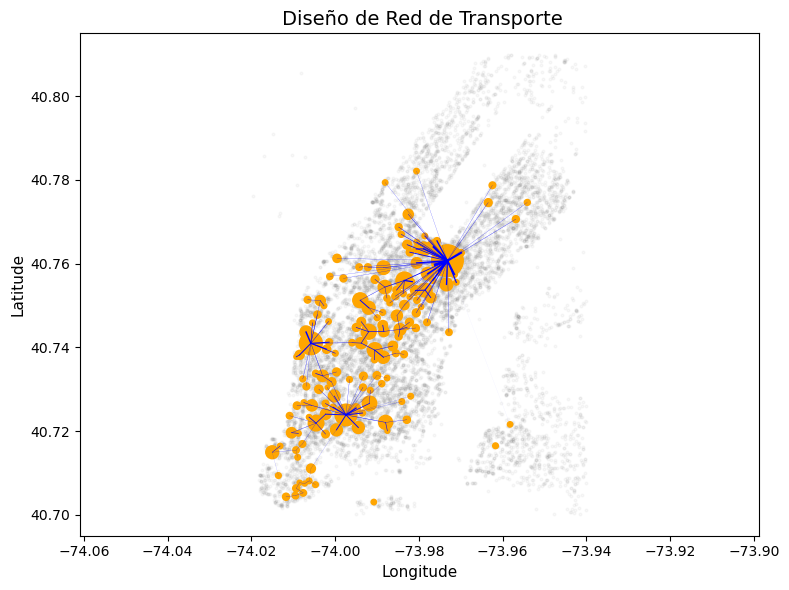

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

#Mostrar los puntos para visualizar la ciudad de NY
ax.scatter(df['Lon'], df['Lat'], s=4, alpha=.05, c="gray")

#Dibujar los grupos con el tamaño basado en la cantidad de puntos/viajes de Uber que tienen los grupos.
plt.scatter(x=dfMST2['Lon'],y=dfMST2['Lat'], s=dfMST2['NumPoints'], c= "orange")


#Dibujar los bordes con un ancho basado en el peso.

krus = g.kruskal()

#Crear una nueva columna con el peso en números positivos.
krus["weight_positive"] = -krus["weight"]

for num in range(len(krus)):
    c1 = krus.loc[[num]]['id_a'].item()
    c2 = krus.loc[[num]]['id_b'].item()
    line = (krus.loc[[num]]["weight_positive"].item() - krus["weight_positive"].min()) / (krus["weight_positive"].max() - krus["weight_positive"].min())
    
    x1 = dfMST2.loc[[c1]]['Lon'].item()
    y1 = dfMST2.loc[[c1]]['Lat'].item()
    
    x2 = dfMST2.loc[[c2]]['Lon'].item()
    y2 = dfMST2.loc[[c2]]['Lat'].item()
    
    plt.plot([x1,x2], [y1,y2], linewidth=line*2, color='b')
    
ax.set_xlabel("Longitude", fontsize=11)
ax.set_ylabel("Latitude", fontsize=11)
ax.set_title(" Diseño de Red de Transporte", fontsize=14)

ax.axis('equal')
plt.tight_layout()
plt.show()